# The Great American Coffee Taste Test 
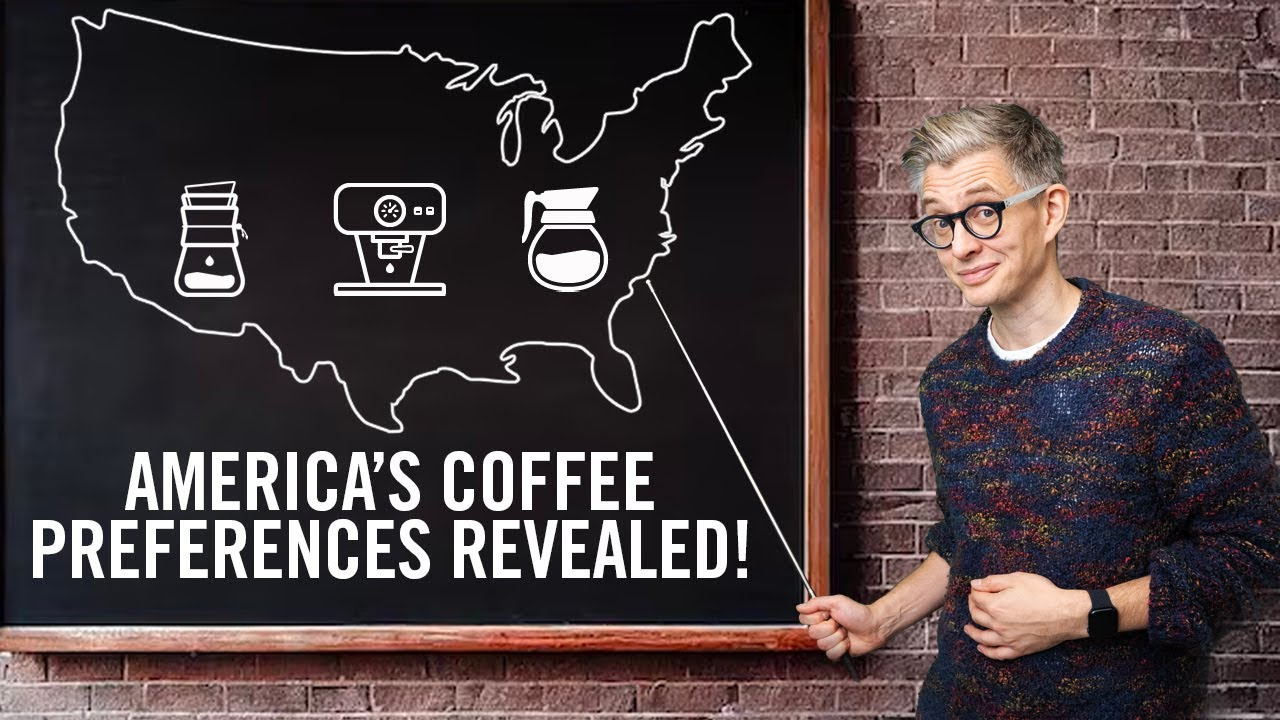

In 2023 James Hoffman surveyed 4000 US residents to understand how they enjoyed coffees A, B, C and D. He also asked some questions about their coffee consumption habits and some basic demographic data.

Watch James discuss his survey and the results [here](https://youtu.be/bMOOQfeloH0?si=da3OMVy5L4jQ5pXx). You can download the .csv of responses [here](https://bit.ly/gacttCSV)

Coffees A (light), B (medium), and C (dark) were all washed coffees but differed by roast level. 
Coffee D was a naturally processed coffee with more fruity, fermented flavours. 
 

__My primary goal in this analysis is to answer 2 questions:__

1) What is the consensus on the tasting notes of the different coffees?
2) How does response differ among different demographics and consumers?

[SKIP TO VISUALISATIONS](#3.-What's-this-coffee-like?)

## 1. Imports and Functions

In [ ]:
import pandas as pd
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

sns.set_palette('deep')

def colToCloud(col):
    """This function takes a column like a_notes. 
    It removes any special characters and creates a dictionary where keys are words in the column and values are frequency.
    The dictionary ignores any common words that would not add meaning to a word cloud.
    The function returns a wordcloud object using the dictionary, in the shape of a coffee bean. """
    
    col_string = re.sub('\W+',' ', ' '.join(col.dropna().to_list()).lower())
    freq_dict = {}

    # making dict for counting frequencies
    for text in col_string.split(" "):
        text = text.strip()
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be|this|it|very|like|would|but|bit|finish|was|t|coffee|roast|\
        |me|my|some|i|when|little|more|slight|had|cooled|really|feel|not|too|which|did|favorite|mine|won|maybe|flavor|good|bad|could|would|\
        |b|got|get|way|over|less|least|up", text):
            continue
        val = freq_dict.get(text, 0)
        freq_dict[text] = val + 1

    bean_mask = np.array(Image.open("data/coffee.png"))

    wc = WordCloud(background_color="white", max_words=1000, mask = bean_mask, colormap='copper')
    # generate word cloud
    return wc.generate_from_frequencies(freq_dict)


def acid_bitter(df):
    """ This function takes a dataframe containing _acidity and _bitterness columns
    It returns the information in a long form df with columns: coffee, acidity, bitterness"""
    
    #create long format df with variable (e.g. a_acidity), and value (corresponding acidity score)
    acid = pd.melt(df.filter(like='_acidity'), value_name='acidity', var_name='coffee')
    acid.coffee = acid.coffee.map(lambda x: x[0].upper()) #e.g. b_acidity --> B
    
    #create long format df with variable (e.g. b_bitterness), and value (corresponding bitterness score)
    bitter = pd.melt(df.filter(like='_bitterness'), value_name='bitterness') 
    bitter.variable = bitter.variable.map(lambda x: x[0].upper()) 
    
    #concatenate column-wise, just taking the values from bitter i.e. the corresponding bitternesses
    return pd.concat([acid,bitter.bitterness],axis=1).rename({'variable':'coffee'}, axis=1)

def colToValuePercentage(groupcol,valcol,df):
    """Takes a col to be grouped by, and a col to supply value counts of each group.
    Returns seaborn-friendly df. Columns containing: group, value, percentage this value makes up of group."""
    
    df = df.groupby(groupcol,as_index=False)[valcol].value_counts(normalize=True)\
    .rename({'proportion':'percent'}, axis=1)
    df.percent*=100
    return df.round(2)

def boolcolsToPercentage(boolcols, df, groupcol=False):
    """This function takes a df, a list of boolean columns, and an optional column to groupby.
    If groupcol==False, a series containing the percentage of True values for each boolcol is returned.
    If groupcol, a df containing the percentage True of each boolcol in each group is returned"""
    
    if groupcol:
        grouped = df.groupby(groupcol)[boolcols]
        grouped_freq = pd.concat([grouped.sum(),grouped.size()],axis=1).rename({0:'count'}, axis=1)
        grouped_pct = grouped_freq.div(grouped_freq['count'],axis=0).mul(100)
        return grouped_pct.drop('count',axis=1)
    else:
        df = df[boolcols]
        return (df.sum()/len(df)).mul(100).sort_values(ascending=False)

## 2. Cleaning

We have a lot of columns in our data set. But some of them contain all/mostly null values. Below I get rid of any columns that are less than 15% full then check how many are remaining. 

In [ ]:
gactt = pd.read_csv('data/GACTT_RESULTS_ANONYMIZED_v2.csv')
gactt_clean = gactt.dropna(thresh=len(gactt)*0.15, axis = 1).copy() #having looked at gactt.info(), I have set the threshold for keeping a column at 15% non-null
gactt_clean.drop('Submission ID', axis=1, inplace=True) #let's drop this too as the anonymised names mean nothing to us
print('Rows, Columns =', gactt_clean.shape)

We still have 89 columns! While some columns are irrelevant for our primary questions, they may be useful for our secondary analysis.

So, I'll rename them all to make the dataframe a bit easier to use. 

In [ ]:
new_col_names = ['age', 'cups_pd', 'where', 'home_drinker', 'office_drinker', 'ongo_drinker', 'cafe_drinker',\
                 'otherplace_drinker', 'brew_method', 'pourover_user', 'frenchpress_user', 'espresso_user', 'dripbrew_user',\
                 'pod_user', 'instant_user', 'beantocup_user', 'coldbrew_user', 'extract_user', 'othermethod_user', 'othermethods',\
                 'where_ongo', 'chain_buyer', 'localcafe_buyer', 'drivethru_buyer', 'specialty_buyer', 'delisupermarket_buyer',\
                 'other_buyer', 'fave_drink', 'adder', 'no_adder', 'milk_adder', 'sugar_adder', 'syrup_adder', 'other_adder',\
                 'kind_of_dairy', 'whole_milker', 'skim_milker', 'halfhalf_milker', 'creamer_milker', 'flavecreamer_milker',\
                 'oat_milker', 'almond_milker', 'soy_milker', 'other_milker', 'prior_preference', 'strength_preference',\
                 'roast_preference', 'caffeine_preference', 'expertise_selfeval', 'a_bitterness', 'a_acidity', 'a_rating',\
                 'a_notes', 'b_bitterness', 'b_acidity', 'b_rating', 'b_notes', 'c_bitterness', 'c_acidity', 'c_rating', 'c_notes',\
                 'd_bitterness', 'd_acidity', 'd_rating', 'd_notes', 'abc_preference', 'ad_preference', 'abcd_preference', 'workplace',\
                 'monthly_spend', 'why', 'tastegood_reason', 'caffeine_reason', 'ritual_reason', 'digestive_reason', 'other_reason',\
                 'like_taste', 'origin_knowledge', 'most_paid_for_cup', 'most_willingtopay_for_cup', 'good_vfm_cafe', 'equipment_spend_5years',\
                 'good_vfm_equipment', 'gender', 'education', 'race', 'employment', 'kids', 'politics']

gactt_clean.columns = new_col_names

### 2.1 Cleaning Brew Method Data
There is a serious oversight in the questionnaire: The omission of AeroPress as a brew method. This lead to more than 2/3 of the "Other Methods" being AeroPress making it a significant brew method in it's own right (6th most popular overall). Moka was the 2nd most popular other method. 

I have corrected this oversight, using regex to identify aeropress and moka users, creating their entries in new ```aero_user``` and ```moka_user``` columns and removing them from the othermethod_user column. 

I have also created a column for people with no brewmethod:```non_user```

In [ ]:
aeropattern = r'(?i)\bAero\s*press?\b|\bAreo\s*press?\b'
mokapattern = r'(?i)\bMoka\s*pot\b|\bMokaPot\b|\bMokka\b'

gactt_clean['aero_user']=gactt_clean.othermethods.str.contains(aeropattern,regex=True)    
gactt_clean['moka_user']=gactt_clean.othermethods.str.contains(mokapattern,regex=True)
gactt_clean.othermethod_user = gactt_clean.othermethod_user.mask(gactt_clean.aero_user | gactt_clean.moka_user, False)

gactt_clean['non_user']=gactt_clean.brew_method.isna()

### 2.2 Adding some numeric columns
For some numeric data, ranges have been given for the respondents to choose between and the data is string, not numeric e.g. age. 

We need to create numeric columns that we can use for visualisations and ordering, while retaining a list of the unique values to be used as labels

In [ ]:

gactt_clean.age = gactt_clean.age.map(lambda x: (x.split())[0], na_action='ignore') #removing 'years old'
age_labels = sorted(list(gactt_clean.age.dropna().unique()), key=lambda x: x.strip('<')) 
age_dict = dict(zip(age_labels,range(10,71,10)))
gactt_clean['age_num']=gactt_clean.age.map(age_dict)

cups_labels = ['Less than 1', '1', '2', '3','4', 'More than 4']
cups_dict= dict(zip(cups_labels,range(0,6)))
gactt_clean['cups_pd_num'] = gactt_clean.cups_pd.map(cups_dict)

mspend_labels = sorted(list(gactt_clean.monthly_spend.dropna().unique()), key=lambda x: x.strip('<'))
mspend_dict = dict(zip(mspend_labels,range(10,111,20)))
gactt_clean['monthly_spend_num']=gactt_clean.monthly_spend.map(mspend_dict)
mspend_labels = [f'\{x}' if not re.search('>|<',x) else x for x in mspend_labels]#put the \ to protect $ in ticklabels

gactt_clean.equipment_spend_5years.value_counts(dropna=False)
eqspend_labels = sorted(list(gactt_clean.equipment_spend_5years.dropna().unique()), key=lambda x: int(x.split('$')[-1].replace(',','')))
eqspend_ticks =[10,35,75,200,400,750,1500]
eqspend_dict = dict(zip(eqspend_labels, eqspend_ticks))
gactt_clean['eq_spend_num'] = gactt_clean.equipment_spend_5years.map(eqspend_dict)

### 2.3 Cleaning Tasting Data

For our analysis we will need to look primarily at the tasting data. Let's make an index of columns for looking at coffees```abcd```

In [ ]:
abcd = gactt_clean.loc[:,'a_bitterness':'abcd_preference'].columns
print('BEFORE')
gactt_clean[abcd].head()


Looking at the head of the tasting data above we can immediately see we are facing a few nulls. 

I don't mind respondents' who haven't filled in ```_notes``` data, but we need a dataframe where everyone has at least filled in the numeric data, indicating they have tasted and rated __all__ the coffees. Let's, call it ```tasters```.

This is the data we will use most as it has information exclusively on respondents who tried the coffee. 

In [ ]:
tasters = gactt_clean.dropna(subset=gactt_clean[abcd].select_dtypes('number').columns, how='any')
tasters.drop(15,inplace=True) #obviously bad data
tasters[abcd].head()

## 3. What's this coffee like?


In [ ]:
t = tasters[abcd] #Let's create a view of the tasters containing only tasting data and call it t

### 3.1 Most popular?

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=t, x = 'abcd_preference', stat = 'percent', order= sorted(list(t.abcd_preference.dropna().unique())), palette = 'deep',ax=axs[0]);
sns.violinplot(data = t.filter(like='_rating'),ax=axs[1])
axs[0].set_title(f'"Which coffee is your favourite?"({t.abcd_preference.count()} responses)')
axs[1].set_title('Rating distribution')
axs[1].set_xticklabels(['Coffee A','Coffee B','Coffee C','Coffee D']);
axs[0].set_xlabel('Preference')
axs[1].set(ylabel='Rating /5')

__Coffee D ___appears to be___ the clear winner! Hurrah for natural processed coffee.__

It is most frequently named as the favourite coffee, and it's ratings are largely higher than the others. 

However, it is clearly not universally liked, otherwise it wouldn't have any low ratings. In fact, it has the highest number of 1/5 ratings as well as the highest number of 5/5 ratings. We can see this a little more clearly in a histogram. 

In [ ]:
plt.figure(figsize = (10,5))
sns.histplot(data=t.filter(like='_rating'), discrete=True, shrink=0.6, multiple='dodge')
plt.title('Rating count for each coffee')
plt.xlabel('Rating /5');
display(t.filter(like='_rating').mean().to_frame().rename({0:'Mean'},axis=1).round(2))

Now the picture is a little clearer. 

__Coffee D is also the most polarizing!!!__

Although it has the most fans, it also has the most haters. It is marmite coffee.

If we look at the mean ratings, we see it is only very slightly higher than Coffee A. 

By contrast A, B, and C are more commonly given mid-range ratings, they are crowd pleasers, especially A. 
When we think about the types of coffee we have it makes sense:
+ A, B, and C are "normal" coffees just with different levels of roast
+ A is a light roast, giving those fruitier tasting notes that are clearly popular in our sample
+ D is a naturally processed coffee.
    + Without getting too complicated, this imparts sweet fruity flavours, but also some fermented, "funky" flavours which some people really hate.
 
 
It will be interesting how these results are affected when we start focussing on respondents differentiated by coffee drinking habits and other factors, like age and gender.

### 3.2 Tasting notes?

In this section, I am going to convert the qualitative data we have in the ```_notes``` columns to create a ```WordCloud```

In [ ]:
a_cloud = colToCloud(t.a_notes)
b_cloud = colToCloud(t.b_notes)
c_cloud = colToCloud(t.c_notes)
d_cloud = colToCloud(t.d_notes)
clouds = [a_cloud,b_cloud,c_cloud,d_cloud]

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,15))
loop_dict = dict(zip([0,1,2,3],['A','B','C','D']))
i=0
for ax in axs.flatten():
    ax.imshow(clouds[i],interpolation='bilinear')
    ax.axis('off')
    ax.set_title(loop_dict[i])
    i+=1

fig.subplots_adjust(hspace=0)


We can see that B and C are clearly exhibiting the flavours we would associate with "normal" darker roasted coffee: chocolate, nut, earthy.

Our respondents had plenty more to say about A and D, which makes sense as they were the most popular. While both were identified as fruity, A is associated more with citrusy flavours had more chocolatey caramel responses. 

D was associated with a wide range of fruits especially blueberry, it was chocolatey (but not as much), and people definitely identified it's funky, distinct, naturally processed flavour profile. 

__While this method needs more work to identify plurals and remove words that have nothing to do with flavour, it definitely has potential value for educating consumers.__


### 3.3 Acid Bitterness Matrix

Respondents were asked to rate each coffee on how __bitter__ and __acidic__ they were on a scale of 1 to 5. 

These are defining flavour characteristics in all coffee and too much of either can be overwhelming and, frankly, disgusting:
+ bitterness is associated with flavours like nuts and chocolate, bitter coffee tends to be darker roasted
+ acidity is associated with flavours like citrus, green apple, or tart berries, it tends to be lighter roasted

<sub>These flavours are also highly dependent on how the coffee is brewed, but we don't have to worry about that as the samples were pre-brewed, frozen, and sent out so everyone had the same tasting experience.<sub>

In [ ]:
abm = sns.displot(x='bitterness', y='acidity', data=acid_bitter(t), col = 'coffee', discrete=True, col_wrap=2, color = '#8f3371')
abm.figure.subplots_adjust(wspace=0.25, hspace=0.25)
for ax in abm.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_xlabel('bitterness', visible=True)
    ax.set_ylabel('acidity', visible=True)
abm.set_titles(col_template="Coffee {col_name}");

These are bivariate histograms: the darker the square the more respondents there are at those coordinates. For example, many people marked Coffee A as 2/5 bitterness, 4/5 acidic. 

These histograms confirm much of what we have already discovered about these coffees. What is interesting is the strong similarities between B and C, we might have expected C to be more bitter as it is a darker roast. This method, combined with the word clouds, and similar preference data, shows that our respondents struggled to differentiate meaningfully between B and C. 


## 4. Respondents

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
a = sns.countplot(tasters, x='cups_pd_num',saturation=1, ax=axs[0],hue='cups_pd_num', legend=False, palette='flare')
a.set_xticklabels(cups_labels)
a.set_xlabel('Cups per day')
b = sns.countplot(tasters, x = 'expertise_selfeval', saturation=1, ax=axs[1], hue='expertise_selfeval', legend=False, palette='flare')
b.set_xlabel('Expertise (self-evaluated)');

Most of our respondents drink 2 cups a day, there is a good distribution of interest/expertise level across our respondents. Most gave themselves 6 or 7/10, but please bear in mind that these are self_evaluated metrics. 

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
demos = ['gender','age','race','politics']
i=0
sns.set_palette('flare')
for demo in demos:
    sns.barplot(tasters[demo].value_counts(normalize=True).sort_values().reset_index(), y=demo, x='proportion',palette='flare',ax=axs.flatten()[i],saturation=1)
    i+=1
plt.subplots_adjust(hspace=0.3, wspace=0.3)


#### Oh dear!
Our data set is skewed. The respondents are majority white males, mainly between the ages of 25 and 34, and mainly Democrats.

Could this have affected the results on tasting and preference?

## 5. Gender

In [ ]:
cismsk=(tasters.gender == 'Female') | (tasters.gender == 'Male')
gender_pal={'Male':'#e3685c','Female':'#8f3371'}
fig,ax=plt.subplots(1,1,figsize=(15,5))
sns.countplot(tasters.loc[cismsk].sort_values('abcd_preference'),x='abcd_preference', hue='gender', ax=ax, palette=gender_pal, saturation=1)

### Men like coffees A and D, women are far more evenly distributed.
Our initial conclusion that A and D were the most popular coffees may have been misguided, the data has been totally skewed by the number of men and their preferences. 

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
sns.set_palette('deep')
sns.histplot(data=tasters.loc[tasters.gender=='Female'].filter(like='_rating'), discrete=True, shrink=0.6, multiple='dodge',ax=axs[0])
sns.histplot(data=tasters.loc[tasters.gender=='Male'].filter(like='_rating'), discrete=True, shrink=0.6, multiple='dodge',ax=axs[1])
axs[0].set_title('FEMALE')
axs[1].set_title('MALE');
axs[0].set_xlabel('Overall rating /5')
axs[1].set_xlabel('Overall rating /5');

#### Damn, okay, Coffee D is really polarising among women. 
Look at the red bars showing how many times Coffee D received each score/5.

Coffee D is more hated than loved among female respondents (it is most commonly rated 1/5, more than twice as much as any other coffee). It is important to note that women also gave Coffee D more 5/5 ratings than any other coffee, reiterating its polarising nature. 

Coffee A was also less popular among women, it does not have the same spike in 4/5 ratings as it does among men, and receives significantly more 1/5 ratings than Coffees B and C. 

In [ ]:
a=sns.displot(tasters.loc[cismsk].sort_values('ad_preference'), x = 'ad_preference', hue='ad_preference',legend=False, col='gender',\
            palette=({'Coffee A':'#4c72b0', 'Coffee D':'#c44e52'}), alpha=0.8);
a.set_titles('{col_name}');

In [ ]:
b=sns.displot(tasters.loc[cismsk].sort_values('abc_preference'), x = 'abc_preference', col='gender', legend=False, hue='abc_preference',\
           palette=({'Coffee A':'#4c72b0','Coffee B':'#dd8452','Coffee C':'#55a868'}),alpha=0.8);
b.set_titles('{col_name}');

### Men are skewing the data.
Women prefer Coffee A to Coffee D, but this is not because they really like Coffee A, they just hate coffee D. 

Between A,B, and C there is no clear favourite among women whereas men love Coffee A. 

This study would benefit from more female respondents.

## 6. Age

In [ ]:
midagesmsk = tasters.age.isin(age_labels[1:-1])
roastmsk = tasters.roast_preference.str.match('Light|Medium|Dark',na=False)
rating_cols = tasters.filter(like='_rating').columns
age_ratings = tasters.loc[midagesmsk].groupby('age_num',as_index=False)[rating_cols].mean()
age_ratings = age_ratings.melt(id_vars='age_num', value_name='Mean Rating', var_name='Coffee')
age_roasts = colToValuePercentage('age_num','roast_preference',tasters[midagesmsk & roastmsk])

fig, axs = plt.subplots(1,2,figsize=(15,5))
a=sns.lineplot(age_ratings, x='age_num', y='Mean Rating', hue='Coffee',ax=axs[0],marker='o', palette='deep')
b = sns.barplot(age_roasts, x='age_num', y='percent', hue='roast_preference', \
                palette='copper', hue_order=['Dark','Medium','Light'],ax=axs[1])
b.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), ncol=3)

axs[0].set_xticks(range(20,61,10))
for ax in axs:
    ax.set_xlabel('Age')
    ax.set_xticklabels(age_labels[1:-1])

axs[0].set_title('Mean Rating Given by Age Group')
axs[1].set_title('Roast Preference as a Percentage of Each Age Group');


### Coffees A and D decline in popularity with age, while Coffees B and C increase.
This makes sense, especially when we look at the proportion of roast preferences in the different age groups. 
Older respondents react  positively to more traditional, "normal" tasting coffee, reflecting their increased appetite for darker roasts. 

## Brew Methods

In [ ]:
brew_cols = tasters.filter(like='_user').columns
topbrew=boolcolsToPercentage(brew_cols,tasters).iloc[0:6].index
brew_labels=['Pour over',
 'Espresso Machine',
 'French press',
 'Drip brewer',
 'Cold brew',
 'AeroPress',
 'Pod Machine',
 'No Method',
 'Extract (e.g. Cometeer',
 'Instant',
 'Other',
 'Moka Pot',
 'Bean-to-cup']


fig,axs=plt.subplots(1,2,figsize=(15,5))
a=sns.barplot(boolcolsToPercentage(brew_cols,tasters).sort_values(),palette='flare',saturation=1, orient='h',ax=axs[0])
b=sns.lineplot(boolcolsToPercentage(topbrew,tasters,'abcd_preference'),ax=axs[1], palette='bright')
a.set_yticklabels(brew_labels[::-1])
a.set(title='Popularity of Brew Methods', xlabel='% respondents using this method')
b.set(title='Popularity among groups based on favourite coffee', ylabel='% respondents using this method',xlabel='Coffee Preference')

### Pour Over was the most popular brew method, followed by espresso. 
This points to the type of respondent we have. Although pour over is one of the most accessible and affordable methods of specialty coffee brewing, I would not say it is massively popular among the wider population. It ___is___ popular among this group containing many aspiring coffee connoisseurs though. 

Almost 40% of our audience also own/have access to an espresso machine, showing many respondents invest in a decent set up (more on that below). 

Another clue is we have more people regularly faffing about with an aeropress than using a pod machine. Coffee nerds for sure. 

French press is a ubiquitous piece of coffee brewing equipment, used by novices and non-snobby pros alike. The drip brewer is a very popular machine in America, it is the way every coffee is made in an office or suburban home in films and TV. 

### When it comes to brew method among the different coffee fan groups...
We see that there is a significant increase in pour over usage among Coffee A and D fans. This makes sense, coffee A and D will be more like the coffees these respondents brew at home because pour over is popularly used to get all the nuanced flavours from lighter roasts and fruitier coffees. 

Likewise it makes sense that the people who like Coffee C are keener on drip brew machines than other respondents. Drip brew is for making the most normal of normal coffee. 

## Spenders

In [ ]:
tasters.monthly_spend_num.value_counts()

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))

a=sns.boxplot(tasters.sort_values('abcd_preference'), x = 'abcd_preference',y='monthly_spend_num',\
            whis=(10,90), hue='abcd_preference', palette='deep',legend=False, ax=axs[0])

b=sns.boxplot(tasters, x = 'c_rating',y='monthly_spend_num',whis=(10,90), palette='flare',legend=False,ax=axs[1])
a.set(yticks=range(10,111,20),yticklabels=mspend_labels, xlabel='Coffee Preference', ylabel='Monthly Spend', title='Distribution of Spending by Coffee Preference');
b.set(yticks=range(10,111,20),yticklabels=mspend_labels, xlabel='Overall Rating for Coffee C', ylabel='Monthly Spend', title='Distribution of Spending by Coffee C Rating');


### There are outliers in every group, but Coffee D fans clearly spend more monthly on coffee. 
Coffee sellers will want to catch some of that market. 

There are also implications for other groups. We can see on the left that Coffee C fans don't spend as much money, but if we look deeper, on the right: we can see that the people who hate Coffee C spend more money every month than the people that like it. This makes sense as Coffee D lovers are largely Coffee C haters.  

Coffee sellers may not want to capture more of the market where people don't spend much money (Coffee C fans), and prefer to cater for Coffee D lovers. But it also represents a gap in the market to squeeze more money out of people who still appreciate the classic "normal" flavours of coffee. 

Coffee's B and C represent "normal" coffee that is widely available so it makes sense that people who like them won't spend as much. Whereas people that hate that kind of coffee and love new, fruity, experimental coffee are willing to pay a little more. 

In [ ]:
fig=plt.figure(figsize=(9,6))
a=sns.pointplot(tasters.loc[(tasters.espresso_user==True) & midagesmsk], y='eq_spend_num', x='age_num', color = '#94603e', errorbar=None,\
                label='Espresso Machine Users')
b=sns.pointplot(tasters.loc[(tasters.espresso_user!=True) & midagesmsk & (tasters.pourover_user!=True)], y='eq_spend_num', x='age_num', color = '#e8a980', \
                errorbar=None, label='Everyone else')
c=sns.pointplot(tasters.loc[(tasters.pourover_user==True) & midagesmsk & (tasters.espresso_user!=True)], y='eq_spend_num', x='age_num', color = '#302210', errorbar=None,\
                label='Pour over users (excluding espresso users)')
plt.legend(bbox_to_anchor=(1.05,-0.1), ncol=3)
c.set(ylabel='Equipment Spend last 5yrs ($)', xticklabels=age_labels[1:-1], title='Equipment Spend by Age and Brew Method', xlabel='Age');

### You'll spend more if you're an espresso machine user

The difference you spend as an espresso machine user is stark peaking at middle age (when you need the most coffee and have the most disposable income). 

One thing that is not explored is grinders - investment in a good grinder is something many pour over users may opt for, and will push their overall spend many times higher.  

This graph uses means calculated using the midpoints of each range of options (e.g. \\$500 - \\$1000 --> 750) and makes an assumption of >\\$1000 ---> 1500. So the actual spending figures are unlikely to be accurate, but the ___comparison___ between spending on different brew methods is accurate.  


## Experts?

In [ ]:
expert_ratings = tasters.groupby('expertise_selfeval',as_index=False)[rating_cols].mean()
expert_ratings = expert_ratings.melt(id_vars='expertise_selfeval', value_name='Mean Rating', var_name='Rating')
expert_gender = colToValuePercentage('expertise_selfeval','gender',tasters[cismsk])

fig, axs = plt.subplots(1,2,figsize=(15,5))
a=sns.lineplot(expert_ratings, x='expertise_selfeval', y='Mean Rating', hue='Rating',marker='o',palette='deep',ax=axs[0])
b=sns.barplot(expert_gender, x='expertise_selfeval', y='percent', hue='gender', palette=gender_pal, ax=axs[1])


### Those who rated themselves experts rated Coffee D very highly.

They also rated Coffee A relatively highly. 

__BUT__, we can see that those who rated themselves experts were overwhelmingly male. This casts some doubt on the expert consensus, especially in light of the gender skew we have already identified. Interestingly, there is a slight increase in female representation at 10/10 expert rating, and a noticeable dip in Coffee A and D ratings. 

In [ ]:
expert_agg_dict={}
for i in list(rating_cols):
    expert_agg_dict[i] = 'mean'
expert_agg_dict['gender'] = 'count'
print('Mean Ratings by Respondents rating their expertise >= 9/10')
tasters.loc[cismsk & (tasters.expertise_selfeval >= 9),list(rating_cols)+['gender']].groupby('gender').agg(expert_agg_dict).rename({'gender':'count'},axis=1).round(1)

In [ ]:
top4drinkpal=sns.color_palette(["#f93943","#6665DD","#34113f","#00afb5"])
topdrinks = tasters.fave_drink.value_counts().iloc[0:4].index
expert_drinks=colToValuePercentage('expertise_selfeval','fave_drink',tasters[tasters.fave_drink.isin(topdrinks)])
expert_milk=boolcolsToPercentage(['sugar_adder','milk_adder','syrup_adder'],tasters,'expertise_selfeval')\
.melt(ignore_index=False)

fig,axs=plt.subplots(1,2,figsize=(15,5))

a=sns.lineplot(expert_milk, x='expertise_selfeval',y='value',hue='variable', palette='muted',ax=axs[0])
a.legend(title='')
b=sns.lineplot(expert_drinks,x='expertise_selfeval', y='percent', hue='fave_drink',hue_order=topdrinks, palette=top4drinkpal)
b.legend(title='Favourite Drink')

a.set(title='Additions made (% of expert grade)',xlabel='Expertise (self-evaluated)', ylabel='percent')
b.set(title='Top 4 Favourite Drink (% of expert grade)', xlabel='Expertise (self-evaluated)');

### Experts like their coffee unadulterated. 
The percentage of respondents adding anything to their coffee declines as expertise increases. Unsurprisingly, the percentage of people who drink pour overs increases; pour over is frequently enjoyed as a form of coffee unadulterated by milk or any other flavouring. 

In [ ]:
top6brewers=boolcolsToPercentage(brew_cols,tasters).iloc[0:6].index
fig,ax=plt.subplots(1,1,figsize=(10,7))

a=sns.lineplot(boolcolsToPercentage(top6brewers,tasters,groupcol='expertise_selfeval'),palette='bright',ax=ax,)
ax2=a.twinx()
b=sns.lineplot(tasters, x='expertise_selfeval', y='eq_spend_num',ax=ax2,ci=None, color='#ed0789',alpha=0.3, label='Equipment Spend', linewidth=4)
b.legend(bbox_to_anchor=(0.24, 0.75))
a.set(title='Brew Method (% of expert grade) + Average Equipment spend (5yrs)', xlabel='Expertise (self-evaluated)',ylabel='percent')
b.set_ylabel('Equipment monthly spend ($)')

### Most experts use espresso machines and pour overs. 
Unsurprisingly, they spend more money on equipment too. 